In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/True.csv
/kaggle/input/Fake.csv


In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline  # <-- Import Pipeline
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from ipywidgets import interact, widgets
from IPython.display import display
from sklearn import set_config


In [4]:
# Load and prepare the data
print("--- 1. Loading and Preparing Data ---")
true_df = pd.read_csv('/kaggle/input/True.csv')
fake_df = pd.read_csv('/kaggle/input/Fake.csv')
true_df['label'] = 1  # 1 for True
fake_df['label'] = 0  # 0 for Fake
data = pd.concat([true_df, fake_df], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
print("Data loaded successfully.\n")

--- 1. Loading and Preparing Data ---
Data loaded successfully.



In [5]:
## 2. Prepare Text and Split Data
print("--- 2. Preparing and Cleaning TITLE Text ---")
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

data['title_cleaned'] = data['title'].apply(clean_text)

# Prepare data for ML using ONLY the cleaned title
X = data['title_cleaned']
y = data['label']

# Create a Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.\n")


--- 2. Preparing and Cleaning TITLE Text ---
Data split into 22449 training and 22449 testing samples.



In [6]:
data.head()

,title,text,subject,date,label,title_cleaned
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0,breaking gop chairman grassley has had enough...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0,failed gop candidates remembered in hilarious...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0,mike pences new dc neighbors are hilariously ...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1,california ag pledges to defend birth control ...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0,az ranchers living on usmexico border destroy ...



--- 3. Generating Word Clouds for Titles ---


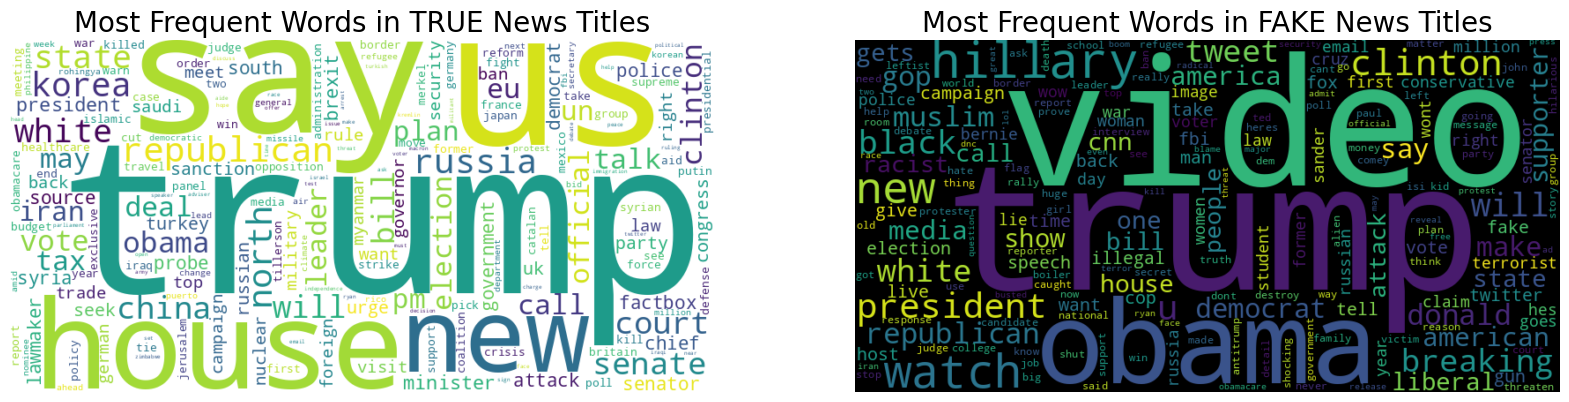

In [7]:
# 3.2 Word Clouds for Titles
print("\n--- 3. Generating Word Clouds for Titles ---")

# Combine all true titles into one big string
true_titles = " ".join(data[data['label'] == 1]['title_cleaned'])
# Combine all fake titles into one big string
fake_titles = " ".join(data[data['label'] == 0]['title_cleaned'])

# Create the word clouds
wordcloud_true = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(true_titles)
wordcloud_fake = WordCloud(width=800, height=400, background_color='black', collocations=False).generate(fake_titles)

# Plot the word clouds side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(wordcloud_true, interpolation='bilinear')
axes[0].set_title('Most Frequent Words in TRUE News Titles', fontsize=20)
axes[0].axis('off')

axes[1].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].set_title('Most Frequent Words in FAKE News Titles', fontsize=20)
axes[1].axis('off')

plt.show()


--- 2. Visualizing Data Distribution ---


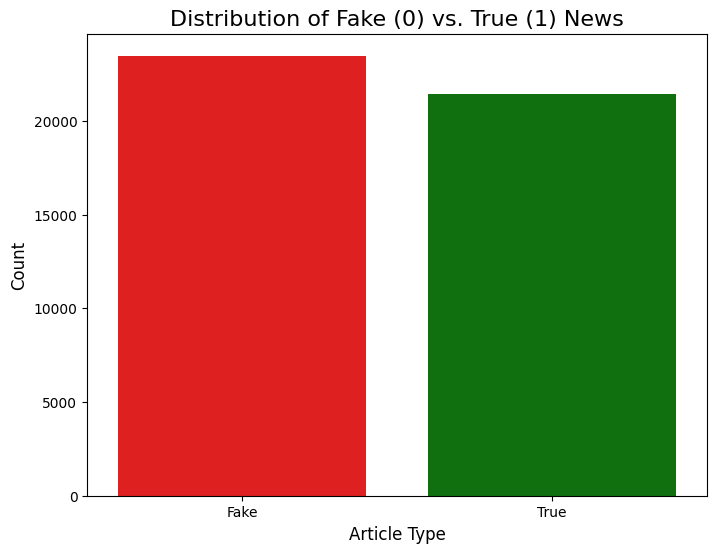

In [8]:
#3.1 Distribution of True vs. Fake News
print("--- 2. Visualizing Data Distribution ---")
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data, palette=['red', 'green'])
plt.title('Distribution of Fake (0) vs. True (1) News', fontsize=16)
plt.xlabel('Article Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Fake', 'True'])
plt.show()

In [11]:
## 3. Train and Evaluate RandomForest Pipeline
print("--- 3. Training a RandomForestClassifier Pipeline ---")

# Create the pipeline object
# It combines the vectorizer and the model into one step.
#rf_pipe = Pipeline([
#    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.8)),
#    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
#])

rf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),  # Use both single words and word pairs
        max_features=5000   # Limit the vocabulary to the top 10,000 words
    )),
    ('model', RandomForestClassifier(
        n_estimators=150,    # Increase the number of trees
        max_depth=50,        # Limit the depth of each tree
        random_state=42
    ))
])

# Fit the entire pipeline on the training data
rf_pipe.fit(X_train, y_train)
print("RandomForest Pipeline training complete.\n")

# Evaluate the model
print("--- RandomForest Model Performance ---")
y_pred_rf = rf_pipe.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=['Fake', 'True']))


--- 3. Training a RandomForestClassifier Pipeline ---
RandomForest Pipeline training complete.

--- RandomForest Model Performance ---
              precision    recall  f1-score   support

        Fake       0.95      0.81      0.88     11737
        True       0.82      0.96      0.89     10712

    accuracy                           0.88     22449
   macro avg       0.89      0.88      0.88     22449
weighted avg       0.89      0.88      0.88     22449



In [12]:
 # display pipelines as interactive diagrams
set_config(display='diagram')
rf_pipe

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('model',
                 RandomForestClassifier(max_depth=50, n_estimators=150,
                                        random_state=42))])

In [23]:
## 5. The Prediction Function
print("\n--- 5. Live Prediction Function ---")

def predict_title(title, model_pipeline):
    """
    Takes a title and a trained model pipeline, then returns a prediction.
    """
    prediction = model_pipeline.predict([title])
    
    if prediction[0] == 1:
        print("Prediction: This title looks like REAL news.")
    else:
        print("Prediction: This title looks like FAKE news.")

# --- Example Test ---
real_title = "Federal judge partially lifts Trump's latest refugee restrictions"
fake_title = "As U.S. budget fight looms, Republicans flip their fiscal script"

#Dwayne 'The Rock' Johnson Dies at 47 After a Terrible Stunt Attempt Failed
#Federal judge partially lifts Trump's latest refugee restrictions

print("\n--- Testing  ---")
predict_title(real_title, rf_pipe)
predict_title(fake_title, rf_pipe)



--- 5. Live Prediction Function ---

--- Testing  ---
Prediction: This title looks like REAL news.
Prediction: This title looks like REAL news.


In [14]:
# --- Create the Interactive Prediction Interface (Corrected) ---
print("--- Live Fake News Detector ---")
print("Enter a news headline below and click 'Check Headline' to get a prediction.")

text_box = widgets.Textarea(
    placeholder='Paste a news headline here...',
    description='Headline:',
    layout={'width': '90%', 'height': '100px'}
)
button = widgets.Button(
    description='Check Headline',
    button_style='success'
)
output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        headline = text_box.value
        if headline.strip():
            # The fix is here: we now pass the 'rf_pipe' as the second argument
            predict_title(headline, rf_pipe)
        else:
            print("Please enter a headline to check.")

button.on_click(on_button_clicked)
display(text_box, button, output)

--- Live Fake News Detector ---
Enter a news headline below and click 'Check Headline' to get a prediction.


Textarea(value='', description='Headline:', layout=Layout(height='100px', width='90%'), placeholder='Paste a n…

Button(button_style='success', description='Check Headline', style=ButtonStyle())

Output()

--- Visualizing the Distribution of True vs. Fake News by Subject ---


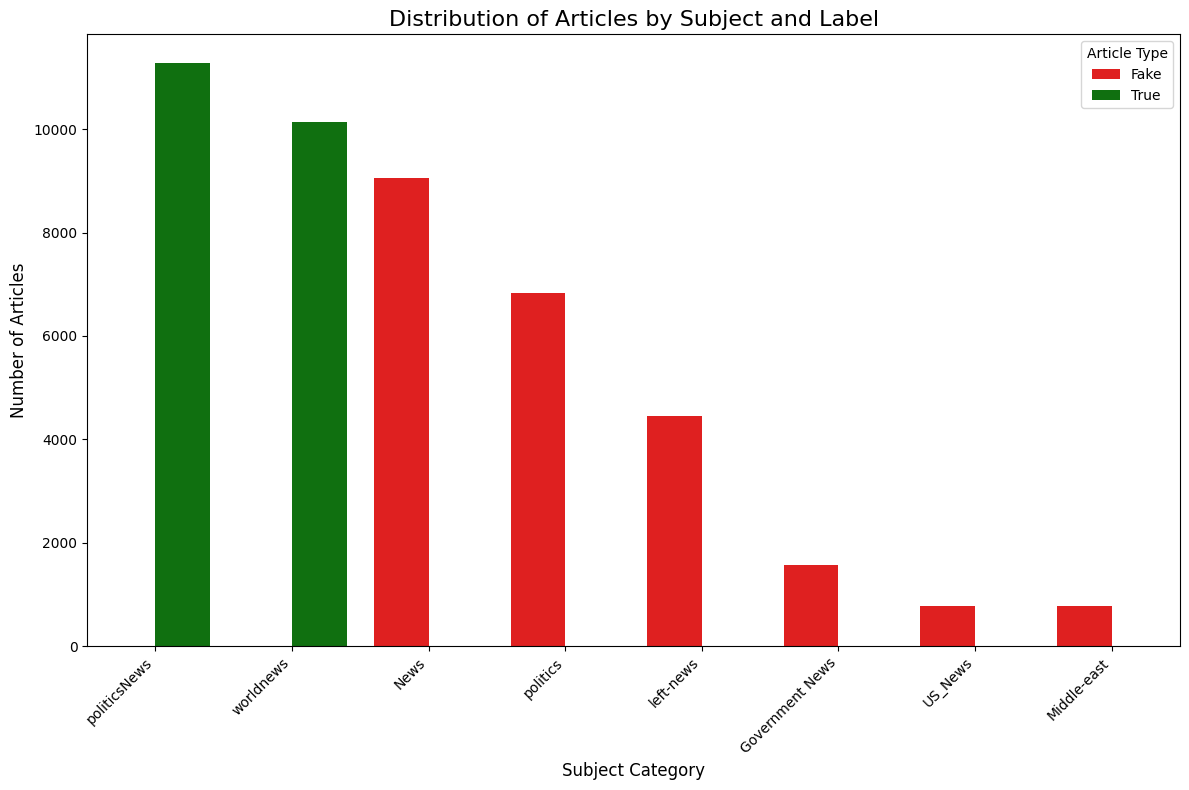

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# This assumes your 'data' DataFrame (with 'subject' and 'label' columns) is already loaded.

print("--- Visualizing the Distribution of True vs. Fake News by Subject ---")

# Set a larger figure size for better readability
plt.figure(figsize=(12, 8))

# Create a count plot. Seaborn handles the counting automatically.
plot = sns.countplot(
    x='subject', 
    hue='label', 
    data=data, 
    palette=['red', 'green'],
    order = data['subject'].value_counts().index # Order bars by frequency
)

# Add a title and labels
plot.set_title('Distribution of Articles by Subject and Label', fontsize=16)
plot.set_xlabel('Subject Category', fontsize=12)
plot.set_ylabel('Number of Articles', fontsize=12)

# Rotate the x-axis labels to prevent them from overlapping
plt.xticks(rotation=45, ha='right')

# Add a legend
plt.legend(title='Article Type', labels=['Fake', 'True'])

# Ensure everything fits neatly
plt.tight_layout()

# Display the plot
plt.show()

--- Visualizing the Distribution of Labels in the Train and Test Sets ---


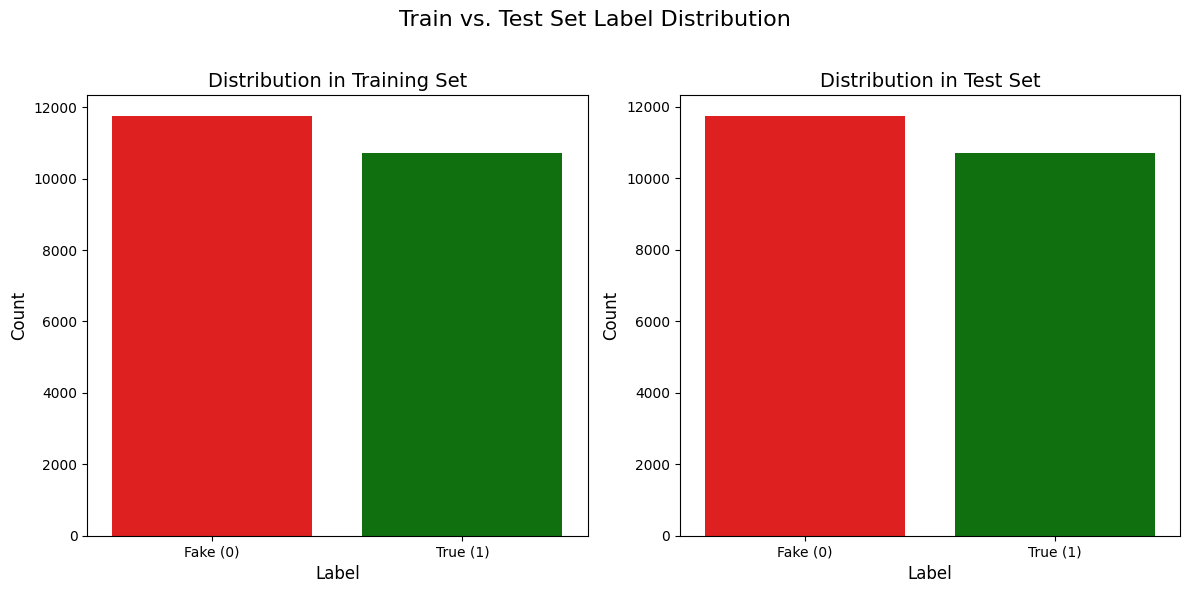

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# This assumes you have already created y_train and y_test from train_test_split

print("--- Visualizing the Distribution of Labels in the Train and Test Sets ---")

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Plot for the Training Set ---
sns.countplot(x=y_train, ax=axes[0], palette=['red', 'green'])
axes[0].set_title('Distribution in Training Set', fontsize=14)
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Fake (0)', 'True (1)'])


# --- Plot for the Test Set ---
sns.countplot(x=y_test, ax=axes[1], palette=['red', 'green'])
axes[1].set_title('Distribution in Test Set', fontsize=14)
axes[1].set_xlabel('Label', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xticklabels(['Fake (0)', 'True (1)'])

# Set a main title for the entire figure
fig.suptitle('Train vs. Test Set Label Distribution', fontsize=16)

# Ensure everything fits neatly
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()

--- Visualizing Model Performance: Train vs. Test ---


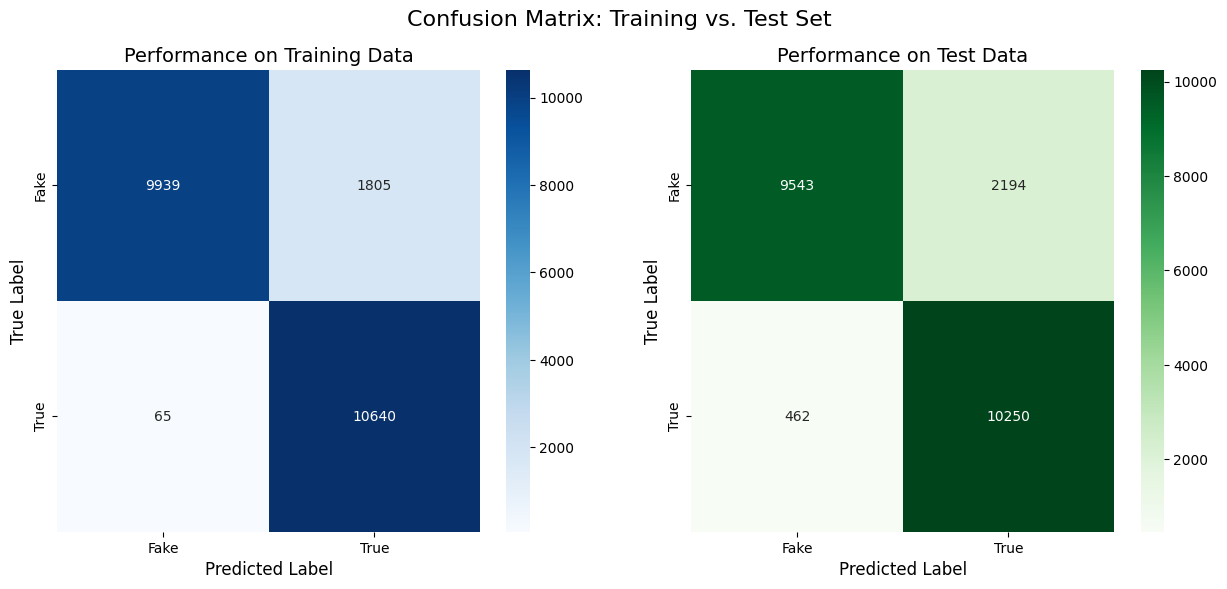

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# This assumes your 'rf_pipe' is already trained and you have X_train, y_train, X_test, y_test

print("--- Visualizing Model Performance: Train vs. Test ---")

# --- Step 1: Get predictions for both sets ---
y_pred_train = rf_pipe.predict(X_train)
y_pred_test = rf_pipe.predict(X_test)

# --- Step 2: Create the confusion matrices ---
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# --- Step 3: Plot the heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for the Training Set
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Performance on Training Data', fontsize=14)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['Fake', 'True'])
axes[0].set_yticklabels(['Fake', 'True'])

# Plot for the Test Set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Performance on Test Data', fontsize=14)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xticklabels(['Fake', 'True'])
axes[1].set_yticklabels(['Fake', 'True'])

fig.suptitle('Confusion Matrix: Training vs. Test Set', fontsize=16)
plt.show()

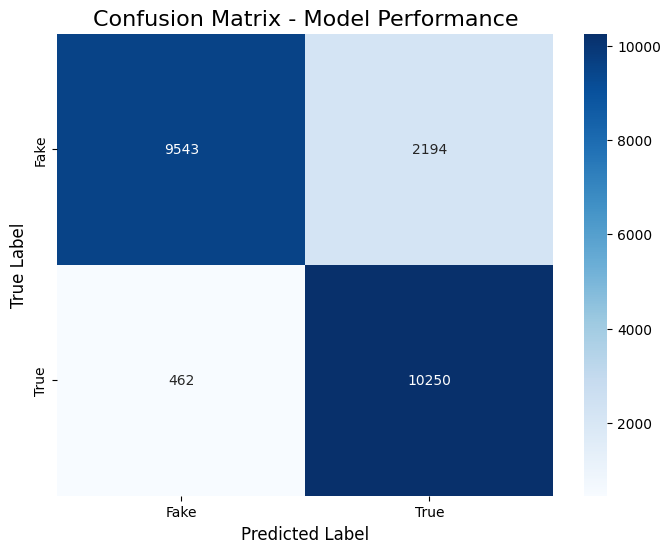


--- Detailed Classification Report ---
              precision    recall  f1-score   support

        Fake       0.95      0.81      0.88     11737
        True       0.82      0.96      0.89     10712

    accuracy                           0.88     22449
   macro avg       0.89      0.88      0.88     22449
weighted avg       0.89      0.88      0.88     22449



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# This assumes your 'rf_pipe' is trained and you have X_test and y_test

# Get predictions for the test set
y_pred = rf_pipe.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True,      # Show the numbers in the squares
            fmt='d',         # Format numbers as integers
            cmap='Blues',    # Use a blue color scheme
            xticklabels=['Fake', 'True'], 
            yticklabels=['Fake', 'True'])

plt.title('Confusion Matrix - Model Performance', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# You can also print the classification report for more details
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Fake', 'True']))

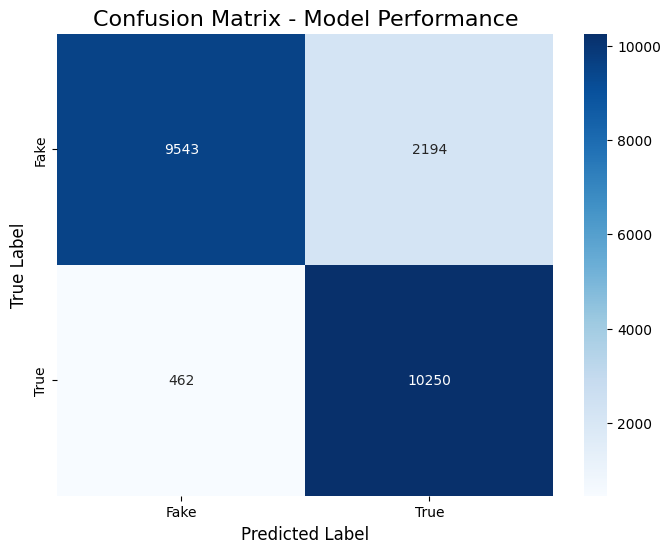

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# This assumes your model is trained and you have y_test and y_pred
# y_test = true labels, y_pred = model's predictions

cm = confusion_matrix(y_test, y_pred)

# Create the heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,      # Show the numbers in the squares
            fmt='d',         # Format numbers as integers
            cmap='Blues',    # Use a blue color scheme
            xticklabels=['Fake', 'True'],
            yticklabels=['Fake', 'True'])

plt.title('Confusion Matrix - Model Performance', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

--- Generating Learning Curve for the RandomForest Model ---


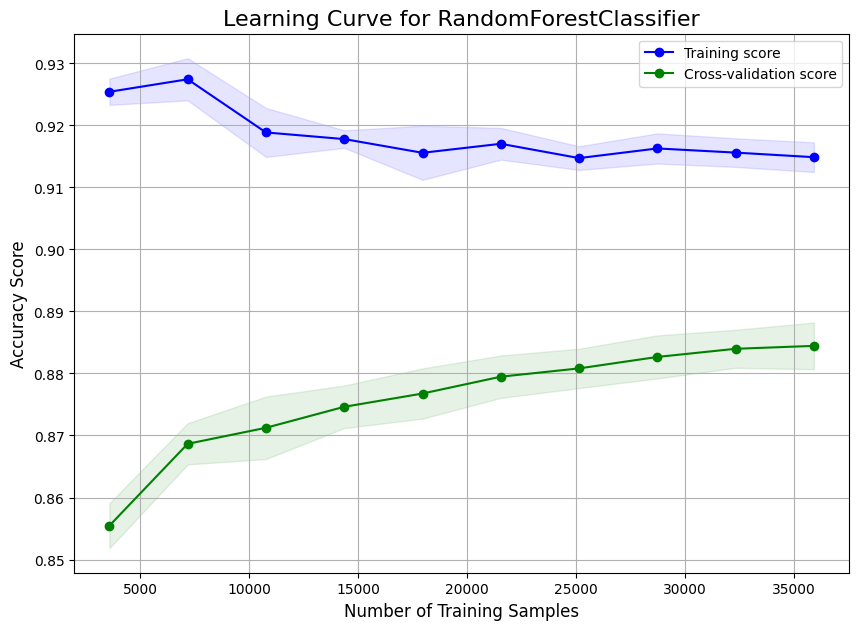

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# This assumes your trained 'rf_pipe', and your full dataset 'X' and 'y' are in memory

print("--- Generating Learning Curve for the RandomForest Model ---")

# The learning_curve function handles the process of training the model on different subset sizes
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_pipe,
    X=X,
    y=y,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1, # Use all available CPU cores for speed
    train_sizes=np.linspace(0.1, 1.0, 10) # Test 10 different training set sizes
)

# Calculate the mean and standard deviation for the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# --- Plot the Learning Curve ---
plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-validation score")

# Add shaded areas to show the variance (standard deviation)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")

plt.title("Learning Curve for RandomForestClassifier", fontsize=16)
plt.xlabel("Number of Training Samples", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.legend(loc="best")
plt.grid()
plt.show()